# Target Brazil Operations Dataset Analysis (2016-2018)

This project analyzes Target’s operations in Brazil using a comprehensive dataset of 100,000 orders placed between 2016 and 2018. The dataset, provided in 8 CSV files, covers key business aspects such as order processing, pricing strategies, payment and shipping performance, customer demographics, product attributes, and customer satisfaction.

## Key Files:
- **customers.csv** – Customer details and locations
- **sellers.csv** – Information on sellers
- **order_items.csv** – Order items, pricing, and product details
- **geolocation.csv** – Geographical data of customers and sellers
- **payments.csv** – Payment methods and amounts
- **orders.csv** – Order status, timestamps, and performance metrics
- **products.csv** – Product categories, names, and prices

## Analysis Goals:
This analysis provides insights into Target’s Brazilian operations, focusing on order trends, pricing, payments, shipping, customer behavior, and product performance. It helps identify challenges, improve customer satisfaction, and optimize strategies.


# Import Liabraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import os
import warnings
warnings.filterwarnings('ignore')

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Badshah1122@',
    database='ecommerce'
)

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Questions:

## 1. How many unique cities do the customers come from?

In [28]:
query = """select count(distinct customer_city) from customers"""
cursor.execute(query)
result = cursor.fetchone()
print(result[0])

4119


## 2. How many customers are in each city?

In [29]:
query = """select distinct customer_city, count(customer_city) total_customers from customers 
group by customer_city order by total_customers desc"""
cursor.execute(query)
result = cursor.fetchall()
# print(result)

df = pd.DataFrame(result, columns=['City', 'Total Customers'])
print(df.head(10))

                    City  Total Customers
0              sao paulo            31080
1         rio de janeiro            13764
2         belo horizonte             5546
3               brasilia             4262
4               curitiba             3042
5               campinas             2888
6           porto alegre             2758
7               salvador             2490
8              guarulhos             2378
9  sao bernardo do campo             1876


## 3. How many orders were placed in the year 2018?

In [30]:
query = """select year(order_purchase_timestamp) as year, count(order_status) as total_order from orders 
group by year having year = 2018  order by total_order desc"""
cursor.execute(query)
result = cursor.fetchall()
# print(result)
total_order_2018 = result[0][1]
print(f"Total Orders Placed in 2018 are: {total_order_2018}")

Total Orders Placed in 2018 are: 54011


## 4. How many orders were placed in each status in the year 2018?

In [31]:
query = '''select  distinct order_status, count(order_status) total_order, year(order_purchase_timestamp) year from orders 
group by order_status, year having year = 2018 order by total_order desc '''
cursor.execute(query)
result = cursor.fetchall()
# print(result)
for i in result:
    print(f"Total {i[0]} orders placed in 2018 are:", i[1])

Total delivered orders placed in 2018 are: 52783
Total shipped orders placed in 2018 are: 568
Total canceled orders placed in 2018 are: 334
Total unavailable orders placed in 2018 are: 145
Total invoiced orders placed in 2018 are: 121
Total processing orders placed in 2018 are: 59
Total created orders placed in 2018 are: 1


## 5. What are the top 5 product categories with the highest sales?

In [32]:
query = '''SELECT 
    UPPER(products.product_category) AS category,
    ROUND(SUM(payments.payment_value), 2) AS sales
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON order_items.order_id = payments.order_id
GROUP BY category
ORDER BY sales DESC'''

cursor.execute(query)
result = cursor.fetchall()
# print(result)
df = pd.DataFrame(result, columns=['Category', 'Sales'])
print(df.head(5))

               Category       Sales
0        BED TABLE BATH  1712553.67
1         HEALTH BEAUTY  1657373.12
2  COMPUTER ACCESSORIES  1585330.45
3  FURNITURE DECORATION  1430176.39
4       WATCHES PRESENT  1429216.68


## 6. How many payments were made in installments versus full payments?

In [33]:
query = '''SELECT 
    CASE
        WHEN payment_installments > 0 THEN 'installment'
        WHEN payment_installments = 0 THEN 'paid'
    END installment_status,
    COUNT(*) AS total_count
FROM
    payments
GROUP BY installment_status'''

cursor.execute(query)
result = cursor.fetchall()
print('Total Installment Orders are:', result[0][1])
print('Total Paid Orders are:', result[1][1]) 


Total Installment Orders are: 103884
Total Paid Orders are: 2


## 7. What percentage of payments were made in installments?

In [34]:
query = """SELECT 
    ROUND(total_installment / total_count * 100, 3) percentage
FROM
    (SELECT 
        SUM(CASE
                WHEN payment_installments > 0 THEN '1'
                WHEN payment_installments = 0 THEN '0'
            END) total_installment,
            COUNT(*) total_count
    FROM
        payments) AS a;"""

cursor.execute(query)
result = cursor.fetchall()
print('Percentage of Installment Orders are:', result[0][0],'%')

Percentage of Installment Orders are: 99.998 %


## 8. How many unique states do the customers come from?

In [35]:
query = '''select count(distinct customer_state) from customers;'''

cursor.execute(query)
result = cursor.fetchall()
print('Total States are:', result[0][0])

Total States are: 27


## 9. Which 10 states have the highest number of customers?

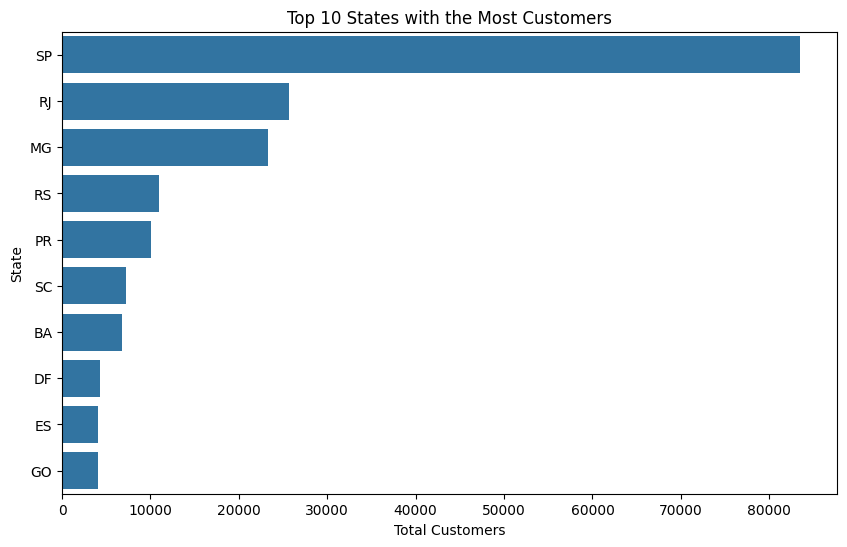

In [36]:
query = '''SELECT 
    customer_state, COUNT(customer_state) total_customer
FROM
    customers
GROUP BY customer_state
ORDER BY total_customer DESC
LIMIT 10;'''

cursor.execute(query)
result = cursor.fetchall()
# print(result)

df = pd.DataFrame(result, columns=['State', 'Total Customers'])
# print(df.head(10))

# Data Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Total Customers', y='State', data=df.head(10))
plt.xlabel('Total Customers')
plt.ylabel('State')
plt.title('Top 10 States with the Most Customers')
plt.show()

## 10. How many orders were placed in each month of the year 2018?

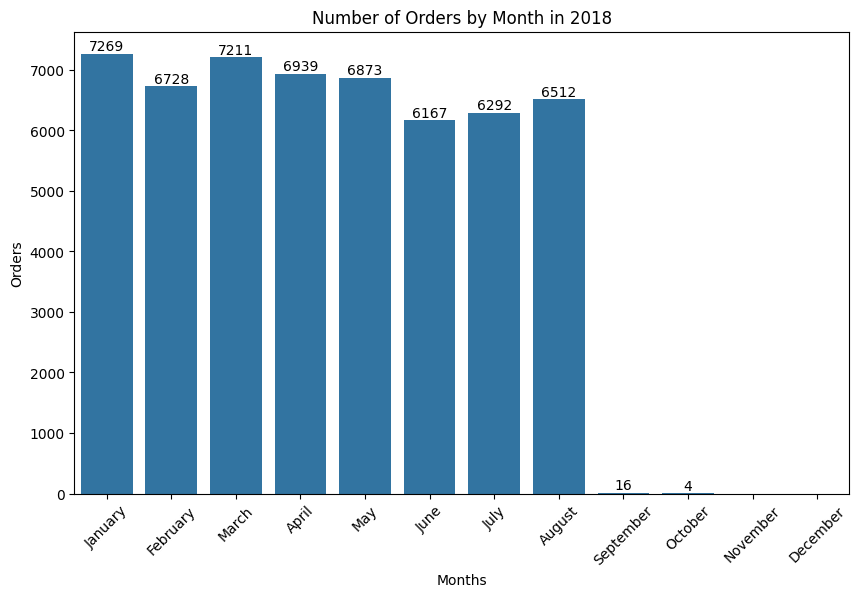

In [37]:
query = '''select monthname(order_purchase_timestamp) months, count(order_id) orders from orders 
where year(order_purchase_timestamp) = 2018 group by months;'''

cursor.execute(query)
result = cursor.fetchall()
df = pd.DataFrame(result, columns=['months', 'orders'])
# print(df)

# Define correct month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert months column to categorical with correct order
df['months'] = pd.Categorical(df['months'], categories=month_order, ordered=True)

# Sort DataFrame by months order
df = df.sort_values('months')
# print(df)

# Data Visualization
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='months', y='orders', data=df)
# Add values on top of bars
# for p in ax.patches:
#     ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),  
#                 ha='center', va='bottom', fontsize=12, color='black')

ax.bar_label(ax.containers[0])
plt.title('Number of Orders by Month in 2018')
plt.xticks(rotation=45)
plt.xlabel('Months')
plt.ylabel('Orders')
plt.show()

## 11. Which product category had the most orders in 2018?

In [38]:
query = '''SELECT 
    category
FROM
    (SELECT 
        UPPER(products.product_category) AS category,
            COUNT(orders.order_id) total_orders_2018
    FROM
        products
    JOIN order_items ON products.product_id = order_items.product_id
    JOIN orders ON order_items.order_id = orders.order_id
    WHERE
        orders.order_purchase_timestamp = 2018
    GROUP BY category
    ORDER BY total_orders_2018 DESC
    LIMIT 1) AS a;'''

cursor.execute(query)
result = cursor.fetchall()
print('Most Popular Category in 2018 is:',result[0][0])

Most Popular Category in 2018 is: HEALTH BEAUTY


## 12. Which city has the highest average number of items per order?

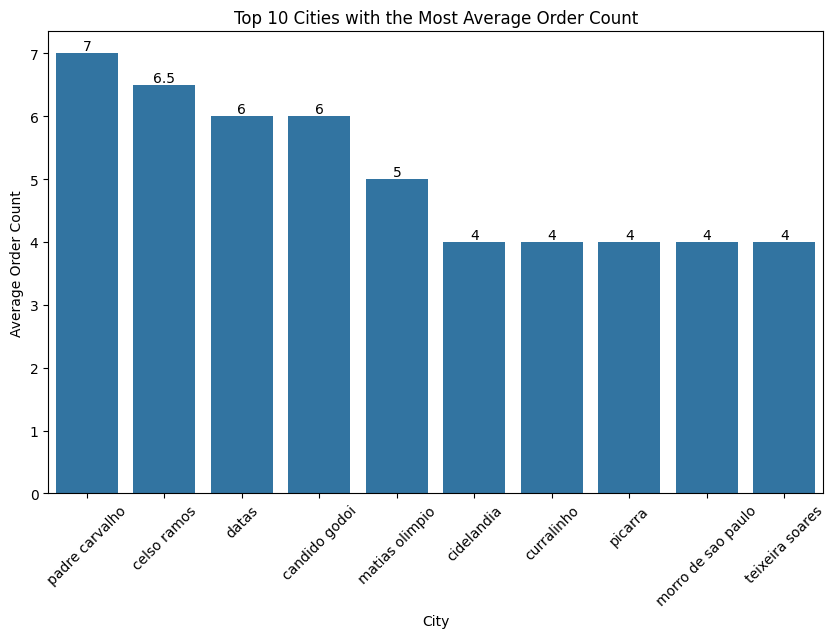

In [39]:
query = '''with total_order_count as (select orders.order_id, 
orders.customer_id, count(order_items.order_id) as order_count from orders 
join order_items on orders.order_id = order_items.order_id 
group by orders.order_id, orders.customer_id)
select customers.customer_city, round(avg(total_order_count.order_count), 1) as average_count from customers 
join total_order_count on customers.customer_id = total_order_count.customer_id 
group by customers.customer_city order by average_count desc;'''                            

cursor.execute(query)
result = cursor.fetchall()
df = pd.DataFrame(result, columns=['City', 'Average Order Count'])
# print(df.head(10))

# Data Visualization
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='City', y='Average Order Count', data=df.head(10))
plt.xlabel('City')
plt.ylabel('Average Order Count')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.title('Top 10 Cities with the Most Average Order Count')
plt.show()

## 13. What is the sales percentage distribution of the top 10 product categories?

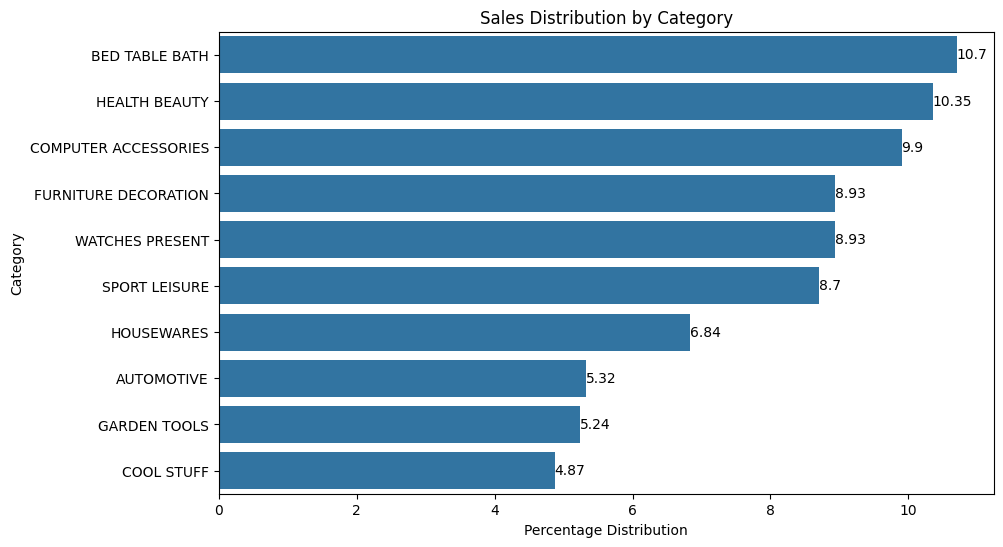

In [40]:
query = '''with sales as (SELECT 
    UPPER(products.product_category) AS category,
    ROUND(SUM(payments.payment_value), 2) AS sales
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON order_items.order_id = payments.order_id
GROUP BY category
ORDER BY sales DESC limit 10),

total_sales as (select sum(payments.payment_value) as total_sales from payments)
select sales.category, sales.sales, round((sales.sales/total_sales.total_sales) * 100,2) percentage_distribution from sales, total_sales; '''

cursor.execute(query)
result = cursor.fetchall()
# print(result)

df = pd.DataFrame(result, columns=['Category', 'Sales', 'Percentage Distribution'])
# print(df.head(10))

# Data Visualization
# Create a bar chart to visualize the sales distribution by category
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Percentage Distribution', y='Category', data=df.head(10))
ax.bar_label(ax.containers[0])
plt.xlabel('Percentage Distribution')   
plt.ylabel('Category')
plt.title('Sales Distribution by Category')
plt.show()

## 14. What is the relationship between order count and average price across product categories?

In [41]:
query = '''select products.product_category category,
count(order_items.product_id) order_count,
round(avg(order_items.price),2) average_price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;'''

cursor.execute(query)
result = cursor.fetchall()
# print(result)

df = pd.DataFrame(result, columns=['Category', 'Order Count', 'Average Price'])
print(df.head(10))

# Correlation Analysis
correlation = df['Order Count'].corr(df['Average Price'])

print('Correlation between Order Count and Average Price:', correlation)

               Category  Order Count  Average Price
0         HEALTH BEAUTY         9670         130.16
1         sport leisure         8641         114.34
2            Cool Stuff         3796         167.36
3  computer accessories         7827         116.51
4       Watches present         5991         201.14
5            housewares         6964          90.79
6           electronics         2767          57.91
7                  None         1603         112.00
8                  toys         4117         117.55
9        bed table bath        11115          93.30
Correlation between Order Count and Average Price: -0.10631514167157557


## 15. Calculate the total revenue generated by each seller and rank them in descending order based on their earnings

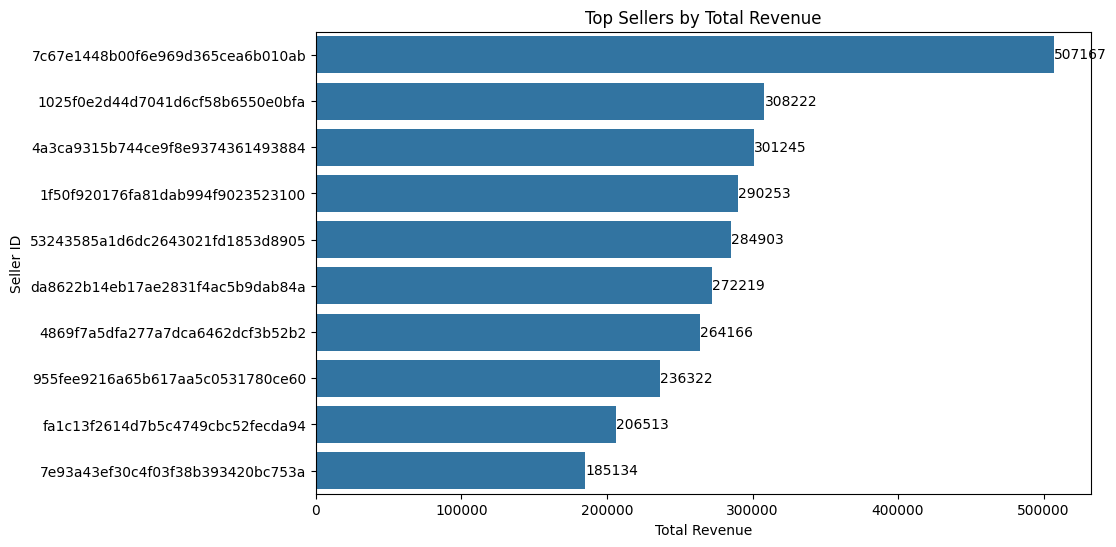

In [42]:
query = '''with total_revenue as (select order_items.seller_id, 
sum(payments.payment_value) total_revenue from order_items 
join payments on order_items.order_id = payments.order_id group by seller_id)
select *, dense_rank() over (order by total_revenue desc) from total_revenue;'''

cursor.execute(query)
result = cursor.fetchall()
# print(result)

df = pd.DataFrame(result, columns=['Seller ID', 'Total Revenue', 'Rank'])
# print(df.head(10))

# Data Visualization    
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Total Revenue', y='Seller ID', data=df.head(10))
ax.bar_label(ax.containers[0])
plt.xlabel('Total Revenue')
plt.ylabel('Seller ID')
plt.title('Top Sellers by Total Revenue')
plt.show()

## 16. What is moving average of payment values for each customer, ordered by purchase timestamp?

In [43]:
query = """ select customer_id, time_stamp, payment,  
round(avg(payment) over (partition by customer_id order by time_stamp rows between 3 preceding and current row),2) 
moving_average from
(SELECT 
    orders.customer_id customer_id,
    orders.order_purchase_timestamp time_stamp,
    payments.payment_value payment
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id) as a;"""

cursor.execute(query)
result = cursor.fetchall()
df = pd.DataFrame(result, columns=['customer_id', 'time_stamp', 'payment', 'moving_avg'])
print(df.head(10))

                        customer_id           time_stamp  payment  moving_avg
0  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74      114.74
1  000161a058600d5901f007fab4c27140  2017-07-16 09:40:32    67.41       67.41
2  0001fd6190edaaf884bcaf3d49edf079  2017-02-28 11:06:43   195.42      195.42
3  0002414f95344307404f0ace7a26f1d5  2017-08-16 13:09:20   179.35      179.35
4  000379cdec625522490c315e70c7a9fb  2018-04-02 13:42:17   107.01      107.01
5  0004164d20a9e969af783496f3408652  2017-04-12 08:35:12    71.80       71.80
6  000419c5494106c306a97b5635748086  2018-03-02 17:47:40    49.40       49.40
7  00046a560d407e99b969756e0b10f282  2017-12-18 11:08:30   166.59      166.59
8  00050bf6e01e69d5c0fd612f1bcfb69c  2017-09-17 16:04:44    85.23       85.23
9  000598caf2ef4117407665ac33275130  2018-08-11 12:14:35  1255.71     1255.71


## 17. What is the monthly sales amount for each year, along with the running cumulative total of sales over time?

   Year  Month  Payment Value  Cumulative Sales
0  2016      9         252.24            252.24
1  2016     10       59090.48          59342.72
2  2016     12          19.62          59362.34
3  2017      1      138488.04         197850.38
4  2017      2      291908.01         489758.39
5  2017      3      449863.60         939621.99
6  2017      4      417788.03        1357410.02
7  2017      5      592918.82        1950328.84
8  2017      6      511276.38        2461605.22
9  2017      7      592382.92        3053988.14


Text(0.5, 1.0, 'Cumulative Sales Over Time')

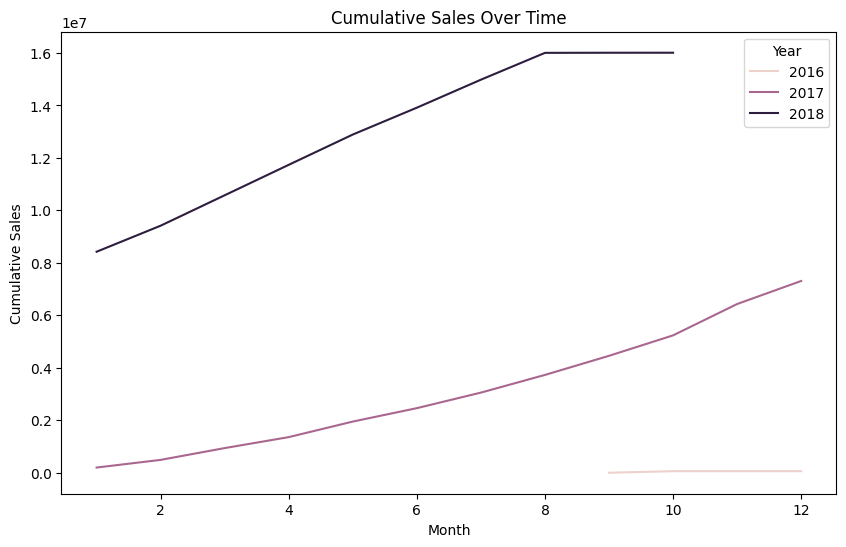

In [44]:
query = '''
select year, month, payment_value, round(sum(payment_value) over (order by year, month), 2) Cumulative_sales from
(select year(orders.order_purchase_timestamp) as year, month(orders.order_purchase_timestamp) as month, 
round(sum(payments.payment_value), 2) payment_value from orders 
join payments on orders.order_id = payments.order_id group by year, month order by year, month) as a;'''

cursor.execute(query)
result = cursor.fetchall()
df = pd.DataFrame(result, columns=['Year', 'Month', 'Payment Value', 'Cumulative Sales'])
print(df.head(10))

# Data Visualization
# Create a line plot to visualize the cumulative sales over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='Cumulative Sales', hue='Year', data=df)
plt.xlabel('Month')
plt.ylabel('Cumulative Sales')
plt.title('Cumulative Sales Over Time')

## 18. What is the total sales for each year along with the running cumulative sales over the years? 

   Year  Payment Value  Cumulative Sales
0  2016       59362.34          59362.34
1  2017     7249746.73        7309109.07
2  2018     8699763.05       16008872.12


Text(0.5, 1.0, 'Cumulative Sales Over Time')

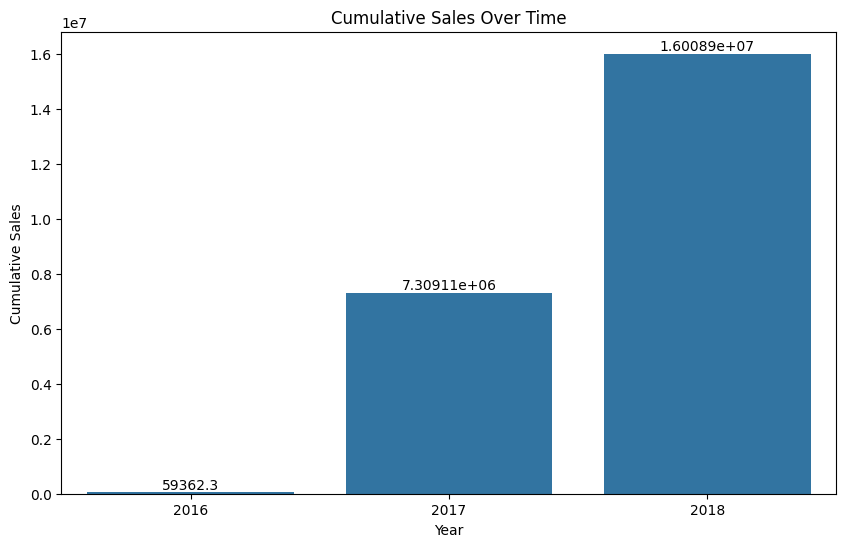

In [45]:
query = '''select year, payment_value, round(sum(payment_value) over (order by year), 2) Cumulative_sales from
(select year(orders.order_purchase_timestamp) as year, round(sum(payments.payment_value), 2) payment_value from orders 
join payments on orders.order_id = payments.order_id group by year order by year) as a;'''

cursor.execute(query)
result = cursor.fetchall()
df = pd.DataFrame(result, columns=['Year', 'Payment Value', 'Cumulative Sales'])
print(df.head(10))

# Data Visualization
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Year', y='Cumulative Sales', data=df)
ax.bar_label(ax.containers[0])
plt.xlabel('Year')
plt.ylabel('Cumulative Sales')
plt.title('Cumulative Sales Over Time')


## 19. What is the yearly sales, cumulative sales over the years, and the year-over-year (YoY) growth rate in sales?

   Year  Payment Value  Cumulative Sales  YOY Growth Rate
0  2016       59362.34          59362.34              NaN
1  2017     7249746.73        7309109.07          12112.7
2  2018     8699763.05       16008872.12             20.0


Text(0.5, 1.0, 'YOY Growth Rate Over Time')

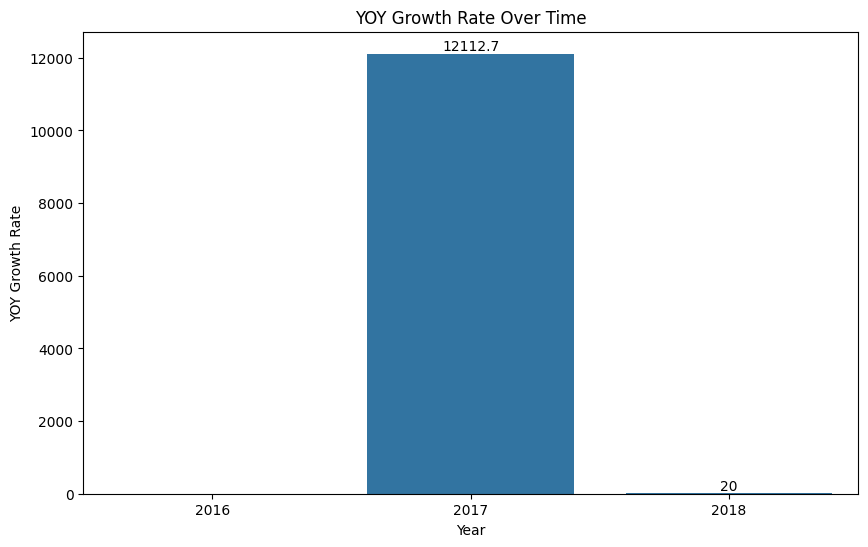

In [46]:
query = '''select year, payment_value, round(sum(payment_value) over (order by year), 2) Cumulative_sales, 
round((payment_value - lag(payment_value, 1) over(order by year))/
lag(payment_value, 1) over(order by year) * 100, 2) yoy_growth_rate from
(select year(orders.order_purchase_timestamp) as year, round(sum(payments.payment_value), 2) payment_value 
from orders join payments on orders.order_id = payments.order_id group by year order by year) as a;'''

cursor.execute(query)
result = cursor.fetchall()
df = pd.DataFrame(result, columns=['Year', 'Payment Value', 'Cumulative Sales', 'YOY Growth Rate'])
print(df.head(10))

# Data Visualization
plt.figure(figsize=(10,6))
ax =sns.barplot(x='Year', y='YOY Growth Rate', data=df)
ax.bar_label(ax.containers[0])
plt.xlabel('Year')
plt.ylabel('YOY Growth Rate')
plt.title('YOY Growth Rate Over Time')

## 20. What are the monthly sales, cumulative sales over time, and the month-over-month growth rate in sales?

   Year  Month      Sales  Cumulative Sales  MOM Growth Rate
0  2016      9     252.24            252.24              NaN
1  2016     10   59090.48          59342.72         23326.29
2  2016     12      19.62          59362.34           -99.97
3  2017      1  138488.04         197850.38        705751.38
4  2017      2  291908.01         489758.39           110.78
5  2017      3  449863.60         939621.99            54.11
6  2017      4  417788.03        1357410.02            -7.13
7  2017      5  592918.82        1950328.84            41.92
8  2017      6  511276.38        2461605.22           -13.77
9  2017      7  592382.92        3053988.14            15.86


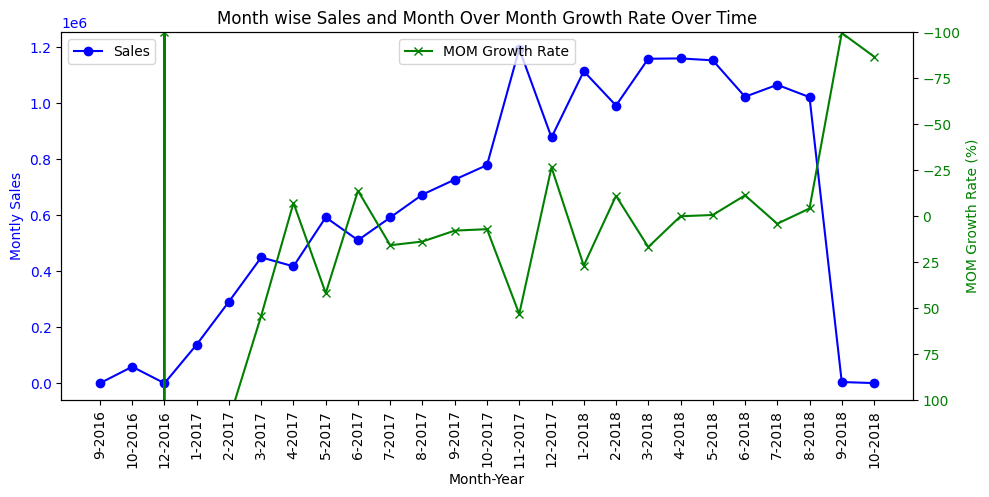

In [47]:
query = '''select year, month, payment_value, round(sum(payment_value) over (order by year, month), 2) Cumulative_sales, 
round((payment_value - lag(payment_value, 1) over(order by year, month))/
lag(payment_value, 1) over(order by year, month) * 100, 2) yoy_growth_rate from
(select year(orders.order_purchase_timestamp) as year, month(orders.order_purchase_timestamp) as month, 
round(sum(payments.payment_value), 2) payment_value from orders join payments on orders.order_id = payments.order_id 
group by year, month order by year, month) as a;
'''

cursor.execute(query)
result = cursor.fetchall()
df = pd.DataFrame(result, columns=['Year', 'Month', 'Sales', 'Cumulative Sales', 'MOM Growth Rate'])
print(df.head(10))

# Data Visualization

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Cumulative Sales
ax1.plot(df['Month'].astype(str) + '-' + df['Year'].astype(str), df['Sales'], color='blue', marker='o', label='Sales')
ax1.set_xlabel('Month-Year')
ax1.set_ylabel('Montly Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=90)


# Plot Month Over Month Growth Rate on secondary axis
ax2 = ax1.twinx()
ax2.plot(df['Month'].astype(str) + '-' + df['Year'].astype(str), df['MOM Growth Rate'], color='green', marker='x', label='MOM Growth Rate')
ax2.set_ylabel('MOM Growth Rate (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(100,-100)

# Add legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')

fig.tight_layout()
plt.title('Month wise Sales and Month Over Month Growth Rate Over Time')
plt.show()

## 21. What percentage of customers placed a new order after their first order, but only after 6 months from their first purchase?

In [48]:
query = '''with a as (select customers.customer_id, min(orders.order_purchase_timestamp) first_order from customers 
join orders on customers.customer_id = orders.customer_id group by customers.customer_id),
b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) second_order from a 
join orders on a.customer_id = orders.customer_id 
and orders.order_purchase_timestamp > first_order and orders.order_purchase_timestamp > date_add(first_order, interval 6 month) 
group by a.customer_id)
select count(distinct a.customer_id) / count(distinct b.customer_id) * 100 as 06_month_new_order from a 
left join b on a.customer_id = b.customer_id;'''

cursor.execute(query)
result = cursor.fetchall()
print('Percentage of 06 Month New Orders:', result[0][0], '%')


Percentage of 06 Month New Orders: None %


## 22. selects only those customers who are among the top three highest spenders each year?

[(2016, 'a9dc96b027d1252bbac0a9b72d837fc6', 1423.550048828125, 1), (2016, '1d34ed25963d5aae4cf3d7f3a4cda173', 1400.739990234375, 2), (2016, '4a06381959b6670756de02e07b83815f', 1227.780029296875, 3), (2017, '1617b1357756262bfa56ab541c47bc16', 13664.080078125, 1), (2017, 'c6e2731c5b391845f6800c97401a43a9', 6929.31005859375, 2), (2017, '3fd6777bbce08a352fddd04e4a7cc8f6', 6726.66015625, 3), (2018, 'ec5b2ba62e574342386871631fafd3fc', 7274.8798828125, 1), (2018, 'f48d464a0baaea338cb25f816991ab1f', 6922.2099609375, 2), (2018, 'e0a2412720e9ea4f26c1ac985f6a7358', 4809.43994140625, 3)]


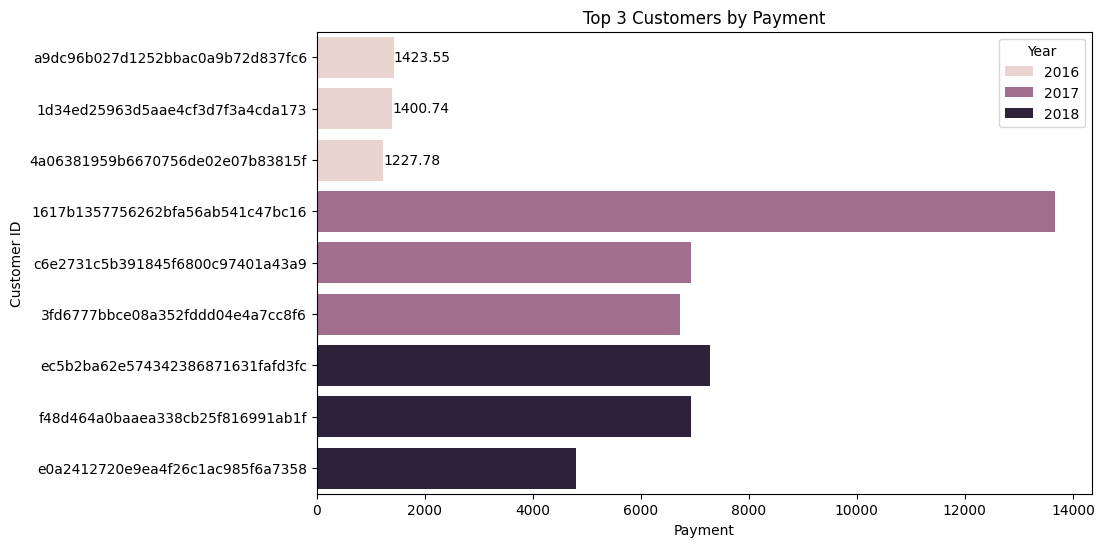

In [49]:
query = '''
with a as (select year(orders.order_purchase_timestamp) year, orders.customer_id customer_id, sum(payments.payment_value) payment
from orders join payments on orders.order_id = payments.order_id group by year, customer_id),
b as (select a.year, a.customer_id, a.payment, dense_rank() over (partition by year order by payment desc) d_rank from a)
select * from b where d_rank <= 3;
'''

cursor.execute(query)
result = cursor.fetchall()
df = pd.DataFrame(result, columns=['Year', 'Customer ID', 'Payment', 'D Rank'])
print(result)

# Data Visualization
# Create a bar chart to visualize the sales distribution by category
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Payment', y='Customer ID', data=df, hue= 'Year')
ax.bar_label(ax.containers[0])
plt.xlabel('Payment')
plt.ylabel('Customer ID')
plt.title('Top 3 Customers by Payment')
plt.show()

# **Summary of Analysis**

Based on the analysis outlined in the document regarding Target's operations in Brazil from 2016 to 2018, the following key points were observed:

1. **Unique Cities**: 
   - Customers hailed from **4,119 unique cities**.

2. **Customers in Each City**:
   - The highest number of customers were located in:
     - São Paulo: **31,080**
     - Rio de Janeiro: **13,764**
     - Belo Horizonte: **5,546**

3. **Total Orders in 2018**:
   - **54,011 orders** were placed in the year 2018.

4. **Order Status in 2018**:
   - The breakdown of order statuses included:
     - Delivered: **52,783**
     - Shipped: **568**
     - Canceled: **334**

5. **Top Product Categories**:
   - The top five categories with the highest sales included:
     - Bed Table Bath
     - Health & Beauty
     - Computer Accessories
     - Furniture Decoration
     - Watches Present

6. **Payment Preferences**:
   - **103,884 payments** were made in installments, while only **2 payments** were made in full.

7. **Percentage of Payments Made in Installments**:
   - **99.998%** of payments were made in installments.

8. **Unique States**:
   - Customers came from **27 unique states** across Brazil.

9. **Top States with the Most Customers**:
   - The states with the highest customer counts were highlighted, with the top ten shown in the analysis.

10. **Monthly Orders in 2018**:
    - A detailed analysis of orders placed each month in 2018 was conducted.

11. **Most Popular Product Category in 2018**:
    - The category with the most orders in 2018 was identified as **Health & Beauty**.

12. **Average Items per Order**:
    - The city with the highest average number of items per order was determined.

13. **Sales Percentage Distribution of Top 10 Product Categories**:
    - The analysis provided insights into the sales distribution percentages among the top categories.

14. **Relationship Between Order Count and Average Price**:
    - A correlation analysis was conducted, showing the relationship between order count and average price across product categories.

15. **Total Revenue by Seller**:
    - The total revenue generated by each seller was calculated and ranked in descending order.

This summary reflects the insights and findings derived from the analysis conducted on the dataset, highlighting crucial aspects of Target's Brazilian operations.